In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [4]:
from torch.utils.data import random_split

dataset = datasets.OxfordIIITPet(
    root='./data',
    split='trainval',
    target_types="category",
    transform=transform,
    download=True
)

test_dataset = datasets.OxfordIIITPet(
    root='./data',
    split='test',
    target_types="category",
    transform=transform,
    download=True
)

classes = dataset.classes
num_classes = len(dataset.classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
def create_model(num_classes):
    model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[6] = nn.Linear(4096, num_classes)
    return model.to(device)

In [6]:
def run_epoch(model, loader, criterion, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss, correct, total = 0, 0, 0

    context = torch.enable_grad() if training else torch.no_grad()
    with context:
        for x, y in tqdm(loader, leave=False):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            preds = output.argmax(dim=1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), correct / total

In [7]:
def train_model(model, epochs, lr):
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(
            model, train_loader, criterion, optimizer
        )

        val_loss, val_acc = run_epoch(
            model, val_loader, criterion
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"TrainLoss: {train_loss:.4f} | "
            f"ValLoss: {val_loss:.4f} | "
            f"TrainAcc: {train_acc*100:.2f}% | "
            f"ValAcc: {val_acc*100:.2f}%"
        )

    return history

In [8]:
def plot_training_curves(results):

    plt.figure(figsize=(12, 6))

    plt.subplot(2,2,1)
    for name, history in results.items():
        plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(2,2,2)
    for name, history in results.items():
        plt.plot(history["val_loss"], label=f"{name} Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Validation Loss")
    plt.legend()

    plt.subplot(2,2,3)
    for name, history in results.items():
        plt.plot(history["train_acc"], label=f"{name} Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.legend()

    plt.subplot(2,2,4)
    for name, history in results.items():
        plt.plot(history["val_acc"], label=f"{name} Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
results = {}

for epoch in [5, 10, 15]:
    print(f"\nTraining with epochs={epoch}")
    model = create_model(num_classes)
    history = train_model(model, epochs=epoch, lr=0.001)
    results[epoch] = history

plot_training_curves(results)


Training with epochs=5


Epoch 1/5 | TrainLoss: 1.3922 | ValLoss: 0.8536 | TrainAcc: 60.22% | ValAcc: 72.83%


Epoch 2/5 | TrainLoss: 0.3889 | ValLoss: 0.7925 | TrainAcc: 87.23% | ValAcc: 76.22%


Epoch 3/5 | TrainLoss: 0.2228 | ValLoss: 0.8086 | TrainAcc: 93.17% | ValAcc: 75.95%


Epoch 4/5 | TrainLoss: 0.1492 | ValLoss: 0.7829 | TrainAcc: 96.26% | ValAcc: 75.82%


Epoch 5/5 | TrainLoss: 0.1034 | ValLoss: 0.8081 | TrainAcc: 97.25% | ValAcc: 75.41%

Training with epochs=10


Epoch 1/10 | TrainLoss: 1.3941 | ValLoss: 0.8483 | TrainAcc: 59.68% | ValAcc: 74.18%


Epoch 2/10 | TrainLoss: 0.3931 | ValLoss: 0.7674 | TrainAcc: 87.47% | ValAcc: 76.90%


Epoch 3/10 | TrainLoss: 0.2369 | ValLoss: 0.8346 | TrainAcc: 91.85% | ValAcc: 75.27%


Epoch 4/10 | TrainLoss: 0.1556 | ValLoss: 0.7809 | TrainAcc: 94.77% | ValAcc: 77.04%


Epoch 5/10 | TrainLoss: 0.1249 | ValLoss: 0.7867 | TrainAcc: 96.30% | ValAcc: 78.12%


Epoch 6/10 | TrainLoss: 0.0917 | ValLoss: 0.7979 | TrainAcc: 97.21% | ValAcc: 77.17%


Epoch 7/10 | TrainLoss: 0.0722 | ValLoss: 0.8045 | TrainAcc: 98.23% | ValAcc: 76.90%


Epoch 8/10 | TrainLoss: 0.0708 | ValLoss: 0.8256 | TrainAcc: 98.27% | ValAcc: 76.63%


Epoch 9/10 | TrainLoss: 0.0822 | ValLoss: 0.8356 | TrainAcc: 97.59% | ValAcc: 76.49%


Epoch 10/10 | TrainLoss: 0.0622 | ValLoss: 0.8061 | TrainAcc: 98.23% | ValAcc: 77.58%

Training with epochs=15


Epoch 1/15 | TrainLoss: 1.3784 | ValLoss: 0.8457 | TrainAcc: 59.54% | ValAcc: 73.78%


Epoch 2/15 | TrainLoss: 0.4049 | ValLoss: 0.7751 | TrainAcc: 86.14% | ValAcc: 77.58%


Epoch 3/15 | TrainLoss: 0.2291 | ValLoss: 0.7725 | TrainAcc: 92.76% | ValAcc: 76.22%


Epoch 4/15 | TrainLoss: 0.1524 | ValLoss: 0.7659 | TrainAcc: 95.31% | ValAcc: 76.36%


Epoch 5/15 | TrainLoss: 0.1084 | ValLoss: 0.8372 | TrainAcc: 96.77% | ValAcc: 75.95%


Epoch 6/15 | TrainLoss: 0.0950 | ValLoss: 0.7839 | TrainAcc: 97.11% | ValAcc: 76.09%


Epoch 7/15 | TrainLoss: 0.0742 | ValLoss: 0.8229 | TrainAcc: 98.06% | ValAcc: 76.90%


Epoch 8/15 | TrainLoss: 0.0685 | ValLoss: 0.8051 | TrainAcc: 98.06% | ValAcc: 76.22%


Epoch 9/15 | TrainLoss: 0.0626 | ValLoss: 0.8478 | TrainAcc: 98.40% | ValAcc: 77.58%


Epoch 10/15 | TrainLoss: 0.0506 | ValLoss: 0.8693 | TrainAcc: 98.91% | ValAcc: 76.09%


Epoch 11/15 | TrainLoss: 0.0478 | ValLoss: 0.8870 | TrainAcc: 98.61% | ValAcc: 75.82%


Epoch 12/15 | TrainLoss: 0.0434 | ValLoss: 0.8820 | TrainAcc: 98.98% | ValAcc: 78.67%


Epoch 13/15 | TrainLoss: 0.0495 | ValLoss: 0.8559 | TrainAcc: 98.44% | ValAcc: 77.31%


Epoch 14/15 | TrainLoss: 0.0506 | ValLoss: 0.9017 | TrainAcc: 98.51% | ValAcc: 77.72%



Training with LR=0.01


Epoch 1/5 | TrainLoss: 5.5608 | ValLoss: 4.5501 | TrainAcc: 54.62% | ValAcc: 66.03%


Epoch 2/5 | TrainLoss: 2.2794 | ValLoss: 4.3857 | TrainAcc: 80.16% | ValAcc: 70.38%


Epoch 3/5 | TrainLoss: 1.7137 | ValLoss: 4.7468 | TrainAcc: 85.19% | ValAcc: 71.60%


Epoch 4/5 | TrainLoss: 1.3172 | ValLoss: 4.6909 | TrainAcc: 88.72% | ValAcc: 71.88%


Epoch 5/5 | TrainLoss: 1.2300 | ValLoss: 5.7334 | TrainAcc: 89.27% | ValAcc: 71.47%

Training with LR=0.001


Epoch 1/5 | TrainLoss: 1.3553 | ValLoss: 0.8870 | TrainAcc: 60.97% | ValAcc: 72.55%


Epoch 2/5 | TrainLoss: 0.3822 | ValLoss: 0.8327 | TrainAcc: 87.84% | ValAcc: 73.23%


Epoch 3/5 | TrainLoss: 0.2251 | ValLoss: 0.8547 | TrainAcc: 92.56% | ValAcc: 75.68%


Epoch 4/5 | TrainLoss: 0.1602 | ValLoss: 0.8182 | TrainAcc: 95.18% | ValAcc: 75.41%


Epoch 5/5 | TrainLoss: 0.1058 | ValLoss: 0.8442 | TrainAcc: 97.11% | ValAcc: 76.36%

Training with LR=0.0001


Epoch 1/5 | TrainLoss: 2.5579 | ValLoss: 1.7383 | TrainAcc: 33.53% | ValAcc: 56.66%


Epoch 2/5 | TrainLoss: 1.2560 | ValLoss: 1.2510 | TrainAcc: 69.53% | ValAcc: 66.17%


Epoch 3/5 | TrainLoss: 0.8997 | ValLoss: 1.0593 | TrainAcc: 78.67% | ValAcc: 69.70%


Epoch 4/5 | TrainLoss: 0.7146 | ValLoss: 0.9601 | TrainAcc: 83.12% | ValAcc: 71.60%


Epoch 5/5 | TrainLoss: 0.5965 | ValLoss: 0.8936 | TrainAcc: 85.94% | ValAcc: 73.78%


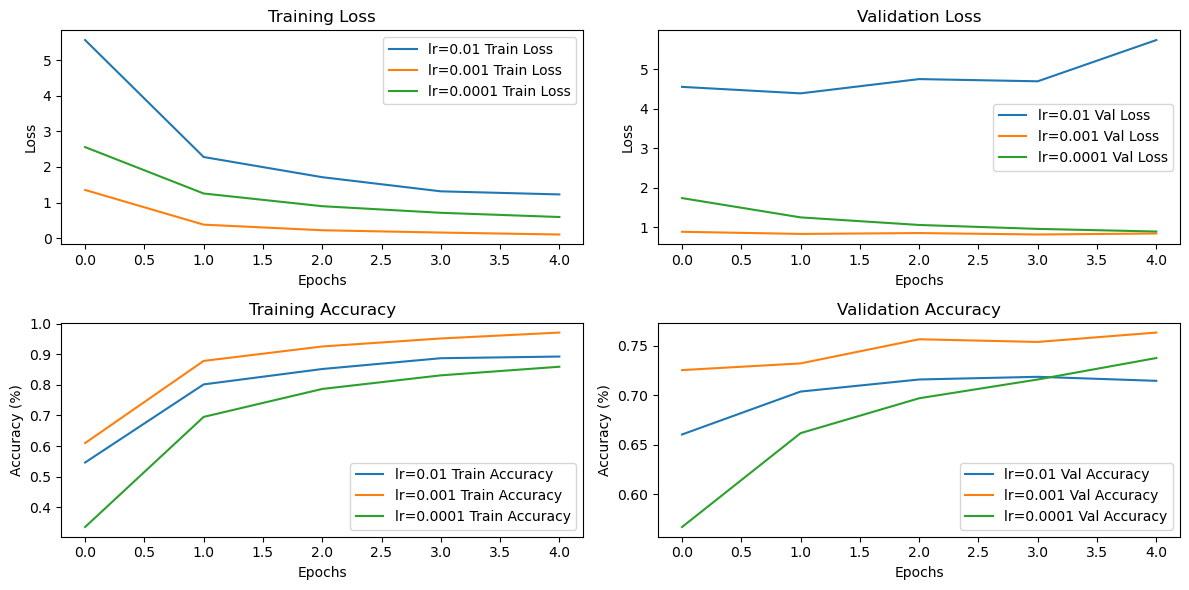

In [10]:
lrs = [1e-2, 1e-3, 1e-4]
results = {}

for lr in lrs:
    print(f"\nTraining with LR={lr}")
    model = create_model(num_classes)
    history = train_model(model, epochs=5, lr=lr)
    results[f"lr={lr}"] = history

plot_training_curves(results)

In [11]:
def show_predictions(model, loader, device, classes, n=8):
    model.eval()

    images, labels = next(iter(loader))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        img = images[i].permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)

        plt.imshow(img)
        plt.title(f"P: {classes[predicted[i]]}\nT: {classes[labels[i]]}", fontsize=8)
        plt.axis('off')
    plt.show()

Epoch 1/5 | TrainLoss: 1.3635 | ValLoss: 0.8662 | TrainAcc: 60.56% | ValAcc: 72.28%


Epoch 2/5 | TrainLoss: 0.3795 | ValLoss: 0.8172 | TrainAcc: 87.36% | ValAcc: 74.46%


Epoch 3/5 | TrainLoss: 0.2172 | ValLoss: 0.8549 | TrainAcc: 93.07% | ValAcc: 73.37%


Epoch 4/5 | TrainLoss: 0.1560 | ValLoss: 0.8352 | TrainAcc: 95.45% | ValAcc: 75.41%


Epoch 5/5 | TrainLoss: 0.1068 | ValLoss: 0.8438 | TrainAcc: 97.08% | ValAcc: 75.27%


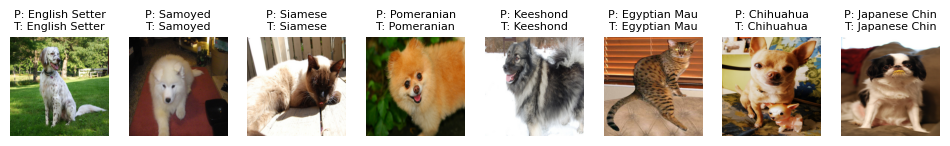

In [12]:
best_model = create_model(num_classes)
history = train_model(best_model, epochs=5, lr=0.001)
show_predictions(best_model, test_loader, device, classes, n=8)